In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tomotools.api as tomo
from tomotools import datasets as ds

/home/aherzing/miniconda3/envs/tomo/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


### Read the input data and produce a version that is spatially binned by a factor of 2

In [14]:
"""Define data location and load into memory using the IMOD reader"""

stack = ds.get_catalyst_tilt_series()
stack.metadata.Tomography.tilts = np.arange(0,180,2)
print("Original data shape: [%s, %s, %s]" % (stack.data.shape))
rebin = stack.rebin(scale=[1, 2, 2])
print("Rebinned data shape: [%s, %s, %s]" % (rebin.data.shape))

Original data shape: [90, 600, 600]
Rebinned data shape: [90, 300, 300]


### Reconstruct the spatially binned data

In [17]:
"""Extract a single slice from the full tilt series for reconstruction inspection.  Slice 300 is chosen as this is far from
   the central contamination line.  This slice is then reconstructed using weighted backprojection as well as SIRT using
   5,10,15,20,25, and 30 iterations.  The WBP reconstruction is simply a 2D Numpy array while all of the SIRT reconstructions
   are stored in a dictionary. NOTE: SIRT is performed using a positivity constraint (threshold = 0.0)"""

singleslice = rebin.isig[:, 150:151].deepcopy()
recFBP = singleslice.reconstruct('FBP', cuda=False)

iters = [5, 50, 100]
recSIRTs = {}
for i in iters:
    recSIRTs[str(i)] = singleslice.reconstruct('SIRT', iterations=i, constrain=True, cuda=False)

INFO:tomotools.recon:Reconstruction volume using FBP
INFO:tomotools.recon:Reconstruction complete
INFO:tomotools.recon:Reconstructing volume using SIRT w/ minimum constraint. Minimum value: 0
INFO:tomotools.recon:Reconstruction complete
INFO:tomotools.recon:Reconstructing volume using SIRT w/ minimum constraint. Minimum value: 0
INFO:tomotools.recon:Reconstruction complete
INFO:tomotools.recon:Reconstructing volume using SIRT w/ minimum constraint. Minimum value: 0
INFO:tomotools.recon:Reconstruction complete


(-0.5, 299.5, 299.5, -0.5)

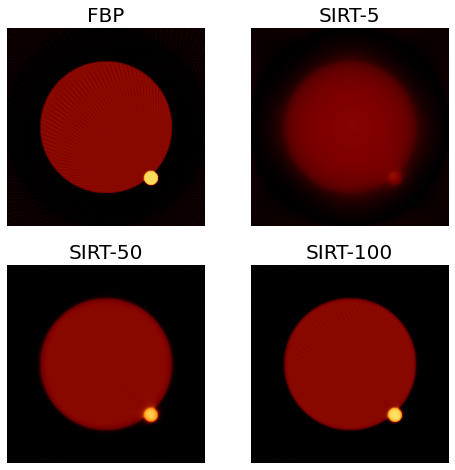

In [28]:
"""Display the various reconstructions for comparison"""

fig,ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].imshow(recFBP.data[0, :, :], clim=[0,3000],cmap='afmhot')
ax[0,0].set_title('FBP',size=20)
ax[0,0].axis('off')

ax[0,1].imshow(recSIRTs['5'].data[0,:,:], clim=[0,3000],cmap='afmhot')
ax[0,1].set_title('SIRT-5', size=20)
ax[0,1].axis('off')

ax[1,0].imshow(recSIRTs['50'].data[0,:,:], clim=[0,3000],cmap='afmhot')
ax[1,0].set_title('SIRT-50', size=20)
ax[1,0].axis('off')

ax[1,1].imshow(recSIRTs['100'].data[0,:,:], clim=[0,3000],cmap='afmhot')
ax[1,1].set_title('SIRT-100', size=20)
ax[1,1].axis('off')

### Reconstruct the entire binned stack
#### Takes less than a minute for each reconstruction

In [6]:
recFBP = rebin.reconstruct('FBP', cuda=False)
recSIRT = rebin.reconstruct('SIRT', iterations=100, constrain=True, cuda=False)

Reconstructing single slice using CPU-based WBP in the Astra Toolbox


100%|████████████████████████████████████████| 512/512 [00:32<00:00, 16.02it/s]


Reconstruction complete
Reconstructing data using CUDA Accelerated SIRT in the Astra Toolbox


100%|████████████████████████████████████████████| 4/4 [00:25<00:00,  6.30s/it]


Reconstruction complete


   ### Save the binned reconstructions

In [16]:
recFBP.save('FBP_Reconstruction.hdf5')
recSIRT.save('SIRT_Reconstruction_100.hdf5')